In [2]:
import numpy as np
import heapq
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Bettors
Assume there are 3 types of bettors:
1) Fans: bet according to what team they support
2) Smart: bet on whichever team offers better value
3) Random: just bet randomly


For a match, we calculate a fair probability and initilize the price using 
$$
p_{i} = (1+b) \times p_\mathrm{fair}
$$
where $b>0$ such that 
$$
\sum_{i} p_{i} > 1.
$$
The odd alway favor the bookmaker.

# The model

For each game, we tread the number of fans, smart and random bettor for each team as a random variable with mean and variance.

we would have some parameters like:
* $\mu_\mathrm{fan,A}$, $\sigma_\mathrm{fan,A}$
* $\mu_\mathrm{fan,B}$, $\sigma_\mathrm{fan,B}$
* $\mu_\mathrm{random}$, $\sigma_\mathrm{random}$
* $\mu_\mathrm{smart}$, $\sigma_\mathrm{smart}$, $P_\mathrm{smart}$

We would assume everything to be Gaussian. Random would be the same for both team(like noise term). $P_\mathrm{smart}$ is the probability that the smart order flow towards the better values side.

# Order arrival
We will assume at each timestemp there is a random chance that any of the type of bettor would bet on their desired team. The probability of seeing a type of bettor is a Poisson process with arrival rate proportional to $X_\mathrm{type} \sim \mathcal{N}(\mu_\mathrm{type},\sigma_\mathrm{type})$.
$$
\lambda_{type} = \frac{X_\mathrm{type}}{N},
$$
where $N$ is some normalization factor (related to the market open duration). 

In [8]:
def generate_arrival_times(rate, time_horizon):
    arrivals = []
    current_time = 0
    while current_time < time_horizon:
        interarrival_time = np.random.exponential(1 / rate)
        current_time += interarrival_time
        if current_time < time_horizon:
            arrivals.append(current_time)
    return arrivals

# Odd adjustment

We need a method to adjust our offer odd with repected to the change in betting volumne $n$. The initial condition should be $p_{i}(n=0) = p_{i}$, where we match our initial offer. One simple method would be a smooth transition(logistic-like)
$$
p_{i}(n) = (1 + b) \times \left[(1 - f_\mathrm{confidence}) \cdot p_\mathrm{fair} + f_\mathrm{confidence} \cdot p_\mathrm{implie}\right]
$$
where $f_\mathrm{confidence} = n/(n+n_\mathrm{threshold})$ is the smoothening factor and $n_\mathrm{threshold}$ is a paramter for controling the smoothness. 

In [51]:
def simulate_betting_market(params=None):
    # Default parameters
    default_params = {
        "P_A_fair": 0.69,       # Fair probability of Team A winning
        "b": 0.03,              # Bias factor(edge)
        "mu_fansA": 8300,      # Mean number of Manchester fans
        "sigma_fansA": 83,     # Std ~ 1/100 of mean
        "mu_fansB": 7000,      # Mean number of Chelsea fans
        "sigma_fansB": 55,     # Std ~ 1/100 of mean
        "mu_random": 3450,     # Mean number of random bettors, 1/4 of (mu_A+mu_B)
        "sigma_random": 34.5,   # Std ~ 1/100 of mean
        "mu_smart": 2000,        # Mean number of smart bettors
        "sigma_smart": 10,      # smart bettor should act consistantly
        "P_smart": 0.90,        # Smart bettor should come to mostly the same conclusion
        "mu_fans_bet": 30,      # Mean bet size for fans
        "sigma_fans_bet": 70,   # Fans can act crazy
        "mu_smart_bet": 100,    # smart bettor should be confident in their choice
        "sigma_smart_bet": 10,  # smart bettor should be confident in their choice
        "mu_random_bet": 30,    # not too far from min_bet_szie
        "sigma_random_bet": 70, # random bettor can act crazy
        "simulation_time": 15*24,# Time horizon
        "min_bet_size": 10      # minimum bet size
    }
    
    if params is not None:
        default_params.update(params)
    
    P_A_fair = default_params["P_A_fair"]
    b = default_params["b"]
    mu_fansA = default_params["mu_fansA"]
    sigma_fansA = default_params["sigma_fansA"]
    mu_fansB = default_params["mu_fansB"]
    sigma_fansB = default_params["sigma_fansB"]
    mu_random = default_params["mu_random"]
    sigma_random = default_params["sigma_random"]
    mu_smart = default_params["mu_smart"]
    sigma_smart = default_params["sigma_smart"]
    P_smart = default_params["P_smart"]
    mu_fans_bet = default_params["mu_fans_bet"]
    sigma_fans_bet = default_params["sigma_fans_bet"]
    mu_smart_bet = default_params["mu_smart_bet"]
    sigma_smart_bet = default_params["sigma_smart_bet"]
    mu_random_bet = default_params["mu_random_bet"]
    sigma_random_bet = default_params["sigma_random_bet"]
    simulation_time = default_params["simulation_time"]
    N = default_params["simulation_time"]
    min_bet_size = default_params["min_bet_size"]

    P_B_fair = 1 - P_A_fair
    Price_A = (1+b)*P_A_fair
    Price_B = (1+b)*P_B_fair
    
    # Store rounded prices for comparison
    last_recorded_Price_A = round(Price_A, 4)
    last_recorded_Price_B = round(Price_B, 4)

    n_fansA = max(1, int(np.random.normal(mu_fansA, sigma_fansA)))
    n_fansB = max(1, int(np.random.normal(mu_fansB, sigma_fansB)))
    n_random = max(1, int(np.random.normal(mu_random, sigma_random)))
    n_smart = max(1, int(np.random.normal(mu_smart, sigma_smart)))

    lambda_fansA = n_fansA / N
    lambda_fansB = n_fansB / N
    lambda_random = n_random / N
    lambda_smart = n_smart / N

    fansA_arrivals = generate_arrival_times(lambda_fansA, simulation_time)
    fansB_arrivals = generate_arrival_times(lambda_fansB, simulation_time)
    random_arrivals = generate_arrival_times(lambda_random, simulation_time)
    smart_arrivals = generate_arrival_times(lambda_smart, simulation_time)

    # Merge arrivals into a single timeline
    events = []
    for time in fansA_arrivals:
        heapq.heappush(events, (time, "fansA"))
    for time in fansB_arrivals:
        heapq.heappush(events, (time, "fansB"))
    for time in smart_arrivals:
        heapq.heappush(events, (time, "smart"))
    for time in random_arrivals:
        heapq.heappush(events, (time, "random"))

    # Initialize tracking variables
    total_bets_A = 0
    total_bets_B = 0
    revenue_collected = 0
    price_history_A = [(0, Price_A)]
    price_history_B = [(0, Price_B)]
    bet_history_A = [(0, 0)]
    bet_history_B = [(0, 0)]
    
    # Track individual bets for PnL calculation
    bets_A = []  # List of (time, amount, price) for bets on A
    bets_B = []  # List of (time, amount, price) for bets on B
    
    # Track bettor counts over time
    bettor_counts = {
        "fansA": 0,
        "fansB": 0,
        "smart": 0,
        "random": 0
    }
    bettor_history = {
        "fansA": [(0, 0)],
        "fansB": [(0, 0)],
        "smart": [(0, 0)],
        "random": [(0, 0)]
    }

    # Process events in chronological order
    while events:
        event_time, bettor_type = heapq.heappop(events)
        
        if bettor_type == "fansA":
            bet_size = max(min_bet_size, np.random.normal(mu_fans_bet, sigma_fans_bet))
            team = "A"
            bettor_counts["fansA"] += 1
        elif bettor_type == "fansB":
            bet_size = max(min_bet_size, np.random.normal(mu_fans_bet, sigma_fans_bet))
            team = "B"
            bettor_counts["fansB"] += 1
        elif bettor_type == "smart":
            bet_size = max(min_bet_size, np.random.normal(mu_smart_bet, sigma_smart_bet))
            # Smart bettors look for relative value
            value_ratio_A = P_A_fair / Price_A
            value_ratio_B = P_B_fair / Price_B
            # With probability P_smart, they choose the better value
            if random.random() < P_smart:
                team = "A" if value_ratio_A > value_ratio_B else "B"
            else:
                team = "B" if value_ratio_A > value_ratio_B else "A"
            bettor_counts["smart"] += 1
        else:  # Random
            bet_size = max(min_bet_size, np.random.normal(mu_random_bet, sigma_random_bet))
            team = random.choice(["A", "B"])
            bettor_counts["random"] += 1
        
        # Update total bets and revenue
        if team == "A":
            total_bets_A += bet_size
            revenue_collected += bet_size
            # Record bet details for PnL calculation
            bets_A.append((event_time, bet_size, Price_A))
        else:
            total_bets_B += bet_size
            revenue_collected += bet_size
            # Record bet details for PnL calculation
            bets_B.append((event_time, bet_size, Price_B))
        
        # Record current state
        bet_history_A.append((event_time, total_bets_A))
        bet_history_B.append((event_time, total_bets_B))
        
        # Record bettor counts
        for bettor_type in bettor_counts:
            bettor_history[bettor_type].append((event_time, bettor_counts[bettor_type]))
        
        # Dynamic price adjustment with smooth transition
        total_bets = total_bets_A + total_bets_B
        betting_volume_threshold = (mu_fansA + mu_fansB + mu_random + mu_smart)/2
        
        # Calculate the betting-implied fair probabilities
        if total_bets > 0:  # Avoid division by zero
            implied_fair_A = total_bets_A / total_bets
            implied_fair_B = total_bets_B / total_bets
            
            # Uses a logistic function for smooth transition from the beginning
            market_confidence = total_bets / (total_bets + betting_volume_threshold)
            
            # Blend initial fair values with market-implied values
            blended_fair_A = (1 - market_confidence) * P_A_fair + market_confidence * implied_fair_A
            blended_fair_B = (1 - market_confidence) * P_B_fair + market_confidence * implied_fair_B
            
            # Apply the margin
            Price_A = (1 + b) * blended_fair_A
            Price_B = (1 + b) * blended_fair_B
            
            # Check if price has changed significantly (to 4 decimal places)
            rounded_Price_A = round(Price_A, 4)
            rounded_Price_B = round(Price_B, 4)
            
            price_changed = (rounded_Price_A != last_recorded_Price_A or 
                             rounded_Price_B != last_recorded_Price_B)
            
            # Only record price updates if there's a meaningful change
            if price_changed:
                price_history_A.append((event_time, Price_A))
                price_history_B.append((event_time, Price_B))
                # Update last recorded prices
                last_recorded_Price_A = rounded_Price_A
                last_recorded_Price_B = rounded_Price_B
    
    # Calculate PnL for different scenarios
    # If Team A wins
    payout_if_A_wins = sum(bet_size / price for _, bet_size, price in bets_A)
    pnl_if_A_wins = revenue_collected - payout_if_A_wins
    
    # If Team B wins
    payout_if_B_wins = sum(bet_size / price for _, bet_size, price in bets_B)
    pnl_if_B_wins = revenue_collected - payout_if_B_wins

    # Return results
    results = {
        "initial": {
            "P_A_fair": P_A_fair,
            "P_B_fair": P_B_fair,
            "Price_A": (1+b)*P_A_fair,
            "Price_B": (1+b)*P_B_fair
        },
        "final": {
            "Price_A": Price_A,
            "Price_B": Price_B,
            "total_bets_A": total_bets_A,
            "total_bets_B": total_bets_B,
            "revenue": revenue_collected
        },
        "bettor_counts": {
            "fansA": n_fansA,
            "fansB": n_fansB,
            "random": n_random,
            "smart": n_smart
        },
        "price_history": {
            "A": price_history_A,
            "B": price_history_B
        },
        "bet_history": {
            "A": bet_history_A,
            "B": bet_history_B
        },
        "bettor_history": bettor_history,
        "pnl_analysis": {
            "if_A_wins": pnl_if_A_wins,
            "if_B_wins": pnl_if_B_wins,
            "expected_pnl": P_A_fair * pnl_if_A_wins + P_B_fair * pnl_if_B_wins
        }
    }
    
    return results

Use this as a reference: https://www.stadium-maps.com/facts/epl_facebook_table.html

we will do A = Manchester United and B = Chelsea and use 1/10000 of the numbers(for speed and performance)


In [61]:
simulation = simulate_betting_market()

print(f"Total Bets on A: ${simulation['final']['total_bets_A']:.2f}")
print(f"Total Bets on B: ${simulation['final']['total_bets_B']:.2f}")
print(f"Revenue Collected: ${simulation['final']['revenue']:.2f}")
print(f"PnL if Team A wins: ${simulation['pnl_analysis']['if_A_wins']:.2f}")
print(f"PnL if Team B wins: ${simulation['pnl_analysis']['if_B_wins']:.2f}")
print(f"Expected PnL: ${simulation['pnl_analysis']['expected_pnl']:.2f}")

Total Bets on A: $672496.71
Total Bets on B: $452842.22
Revenue Collected: $1125338.93
PnL if Team A wins: $38434.56
PnL if Team B wins: $22936.89
Expected PnL: $33630.28


In [62]:
def plot_betting_evolution(results):

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    
    # Extract time series data
    times_A, values_A = zip(*results["price_history"]["A"])
    times_B, values_B = zip(*results["price_history"]["B"])
    bet_times_A, bet_values_A = zip(*results["bet_history"]["A"])
    bet_times_B, bet_values_B = zip(*results["bet_history"]["B"])
    
    # Plot prices
    ax1.plot(times_A, values_A, 'r-', label='Price A')
    ax1.plot(times_B, values_B, 'b-', label='Price B')
    ax1.axhline(y=values_A[0],linestyle='--', color='r')
    ax1.axhline(y=values_B[0],linestyle='--', color='b')
    ax1.set_title('Price Evolution')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot bet volumes
    ax2.plot(bet_times_A, bet_values_A, 'r-', label='Bets on A')
    ax2.plot(bet_times_B, bet_values_B, 'b-', label='Bets on B')
    ax2.set_title('Betting Volume Evolution')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Total Bets')
    ax2.legend()
    ax2.grid(True)
    
    # Plot bettor counts
    for bettor_type, color, linestyle in [
        ("fansA", "r", "-"), 
        ("fansB", "b", "-"),
        ("smart", "g", "--"),
        ("random", "k", ":")
    ]:
        times, counts = zip(*results["bettor_history"][bettor_type])
        ax3.plot(times, counts, color=color, linestyle=linestyle, label=bettor_type)
    
    ax3.set_title('Bettor Count Evolution')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Number of Bettors')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()

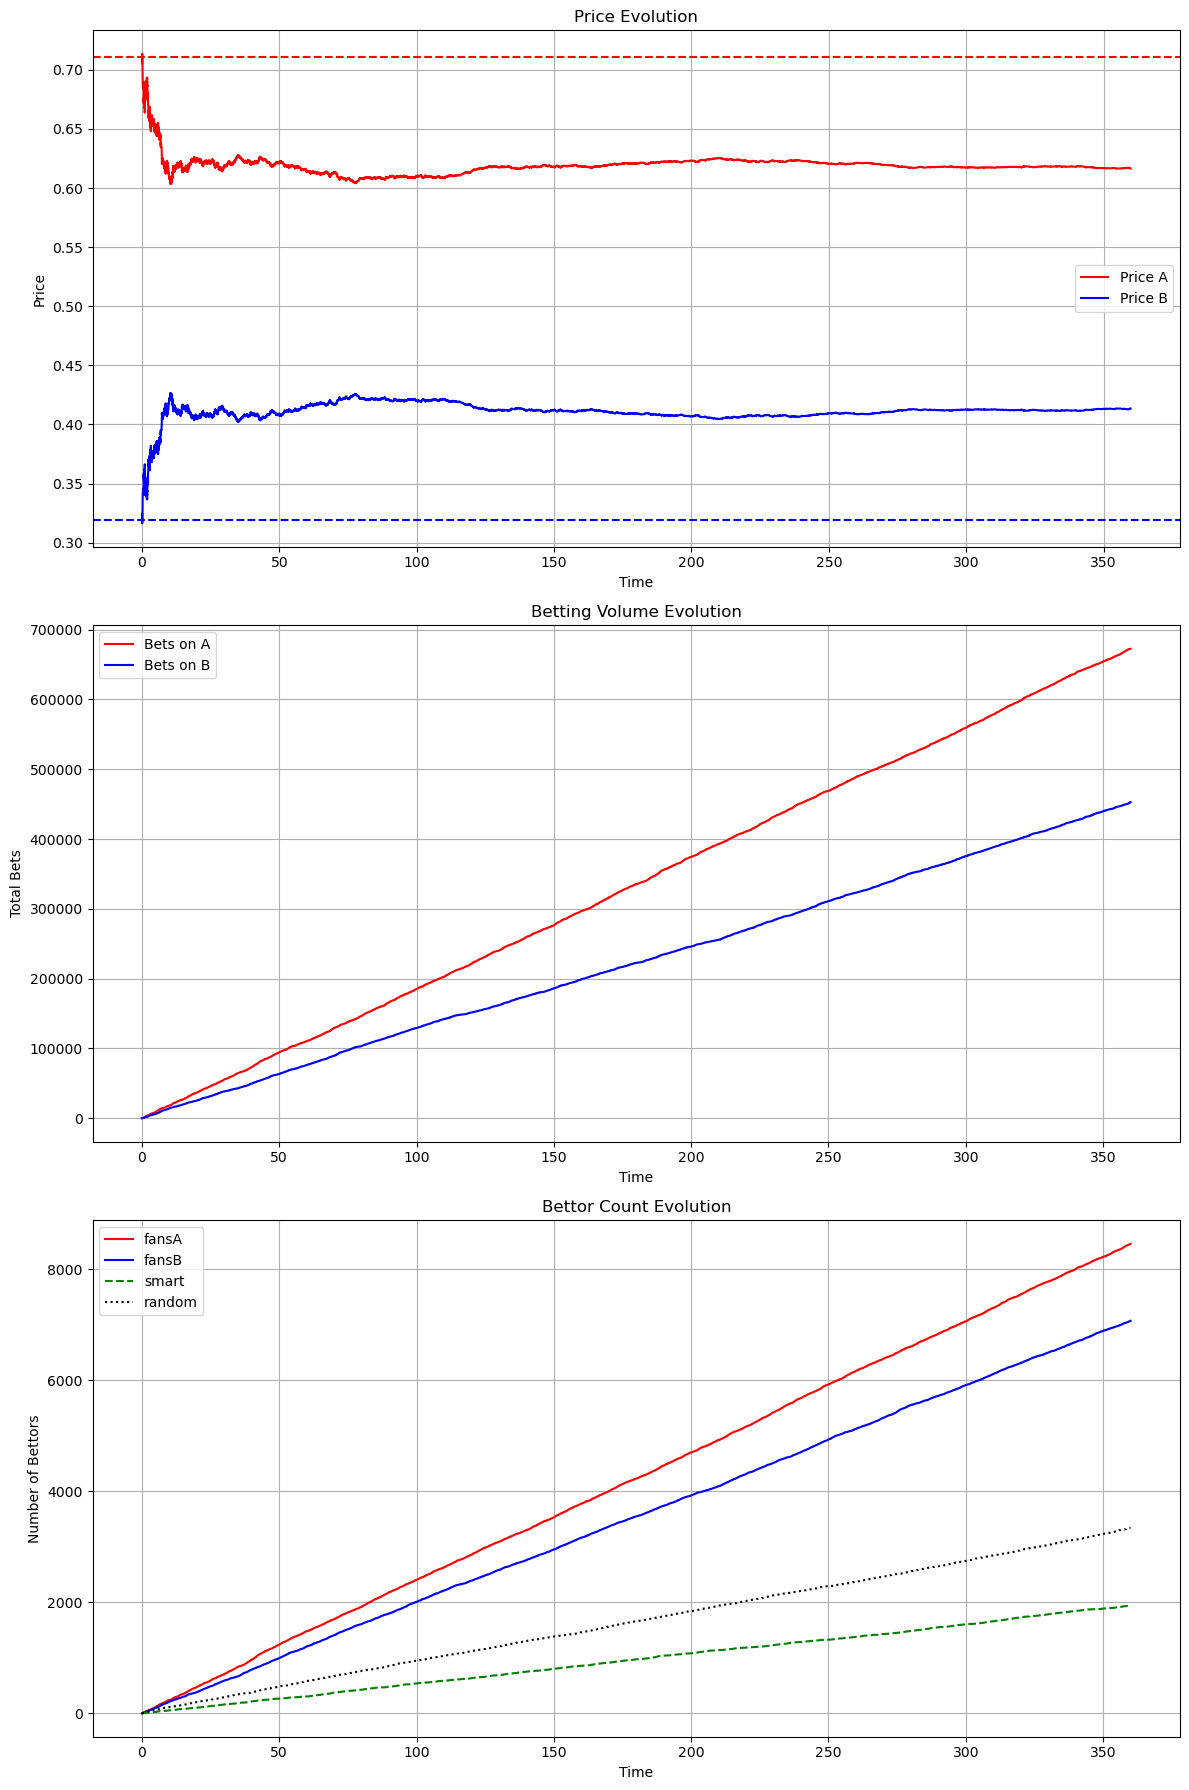

In [63]:
plot_betting_evolution(simulation)

# More sims

What would be the distribution of the expected PnL?

In [65]:
def MC_sims(params=None, N_sims=100):
    sims = []
    for i in range(N_sims):
        if params==None:
            simulation = simulate_betting_market()
        else:
            simulation = simulate_betting_market(params)
        sims.append(simulation)
        if i %(N_sims//10) == 0 and i > 0:
            print(f"Completed {i} of {N_sims} simulations...")
            
    return sims

In [66]:
sims = MC_sims(N_sims=1000)

Completed 100 of 1000 simulations...
Completed 200 of 1000 simulations...
Completed 300 of 1000 simulations...
Completed 400 of 1000 simulations...
Completed 500 of 1000 simulations...
Completed 600 of 1000 simulations...
Completed 700 of 1000 simulations...
Completed 800 of 1000 simulations...
Completed 900 of 1000 simulations...


In [67]:
def plot_MC_results(sims):

    expected_pnls = [sim['pnl_analysis']['expected_pnl'] for sim in sims]
    
    bettor_counts = {
        'fansA': [sim['bettor_counts']['fansA'] for sim in sims],
        'fansB': [sim['bettor_counts']['fansB'] for sim in sims],
        'random': [sim['bettor_counts']['random'] for sim in sims],
        'smart': [sim['bettor_counts']['smart'] for sim in sims]
    }

    total_bettors = [sum(counts) for counts in zip(
        bettor_counts['fansA'], 
        bettor_counts['fansB'], 
        bettor_counts['random'], 
        bettor_counts['smart']
    )]
    
    betting_volumes = {
        'A': [sim['final']['total_bets_A'] for sim in sims],
        'B': [sim['final']['total_bets_B'] for sim in sims]
    }
    total_volume = [a + b for a, b in zip(betting_volumes['A'], betting_volumes['B'])]
    
    expected_pnls = np.array(expected_pnls)
    total_bettors = np.array(total_bettors)
    total_volume = np.array(total_volume)
    
    expected_pnls = np.where(np.isinf(expected_pnls), np.nan, expected_pnls)
    total_bettors = np.where(np.isinf(total_bettors), np.nan, total_bettors)
    total_volume = np.where(np.isinf(total_volume), np.nan, total_volume)
    
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Plot PnL distribution
    ax1 = fig.add_subplot(2, 2, 1)
    sns.histplot(expected_pnls[~np.isnan(expected_pnls)], bins=30, kde=True, ax=ax1)
    mean_pnl = np.nanmean(expected_pnls)
    ax1.axvline(mean_pnl, color='r', linestyle='--', label=f'Mean: {mean_pnl:.2f}')
    ax1.set_title('Distribution of Expected PnL')
    ax1.set_xlabel('Expected PnL')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # 2. Plot total bettor count distribution
    ax2 = fig.add_subplot(2, 2, 2)
    sns.histplot(total_bettors[~np.isnan(total_bettors)], bins=30, kde=True, ax=ax2)
    mean_bettors = np.nanmean(total_bettors)
    ax2.axvline(mean_bettors, color='r', linestyle='--', label=f'Mean: {mean_bettors:.2f}')
    ax2.set_title('Distribution of Total Bettor Count')
    ax2.set_xlabel('Total Bettors')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 3. Plot bettor type breakdown
    ax3 = fig.add_subplot(2, 2, 3)
    bettor_means = []
    bettor_stds = []
    for bt in ['fansA', 'fansB', 'smart', 'random']:
        values = np.array(bettor_counts[bt])
        values = np.where(np.isinf(values), np.nan, values)
        bettor_means.append(np.nanmean(values))
        bettor_stds.append(np.nanstd(values))
    
    ax3.bar(['Team A Fans', 'Team B Fans', 'Smart Bettors', 'Random Bettors'], 
            bettor_means, yerr=bettor_stds)
    ax3.set_title('Average Bettor Counts by Type')
    ax3.set_ylabel('Number of Bettors')
    
    # 4. Plot total betting volume distribution
    ax4 = fig.add_subplot(2, 2, 4)
    sns.histplot(total_volume[~np.isnan(total_volume)], bins=30, kde=True, ax=ax4)
    mean_volume = np.nanmean(total_volume)
    ax4.axvline(mean_volume, color='r', linestyle='--', label=f'Mean: {mean_volume:.2f}')
    ax4.set_title('Distribution of Total Betting Volume')
    ax4.set_xlabel('Total Betting Volume')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    
    plt.tight_layout()
    return fig

def analyze_MC_results(sims):

    expected_pnls = [sim['pnl_analysis']['expected_pnl'] for sim in sims]
    pnl_if_A_wins = [sim['pnl_analysis']['if_A_wins'] for sim in sims]
    pnl_if_B_wins = [sim['pnl_analysis']['if_B_wins'] for sim in sims]
    
    var_95 = np.percentile(expected_pnls, 5)  # 5% Value at Risk
    var_99 = np.percentile(expected_pnls, 1)  # 1% Value at Risk
    
    prob_loss = np.mean([1 if pnl < 0 else 0 for pnl in expected_pnls])
    
    final_prices_A = [sim['final']['Price_A'] for sim in sims]
    final_prices_B = [sim['final']['Price_B'] for sim in sims]
    
    total_bets_A = [sim['final']['total_bets_A'] for sim in sims]
    total_bets_B = [sim['final']['total_bets_B'] for sim in sims]
    total_volumes = [a + b for a, b in zip(total_bets_A, total_bets_B)]
    
    return {
        'pnl': {
            'mean': np.mean(expected_pnls),
            'median': np.median(expected_pnls),
            'std': np.std(expected_pnls),
            'min': np.min(expected_pnls),
            'max': np.max(expected_pnls),
            'var_95': var_95,
            'var_99': var_99,
            'prob_loss': prob_loss,
            'mean_if_A_wins': np.mean(pnl_if_A_wins),
            'mean_if_B_wins': np.mean(pnl_if_B_wins)
        },
        'prices': {
            'mean_final_A': np.mean(final_prices_A),
            'mean_final_B': np.mean(final_prices_B)
        },
        'volume': {
            'mean_total': np.mean(total_volumes),
            'mean_A': np.mean(total_bets_A),
            'mean_B': np.mean(total_bets_B),
            'ratio_A_to_B': np.mean(total_bets_A) / np.mean(total_bets_B)
        }
    }

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


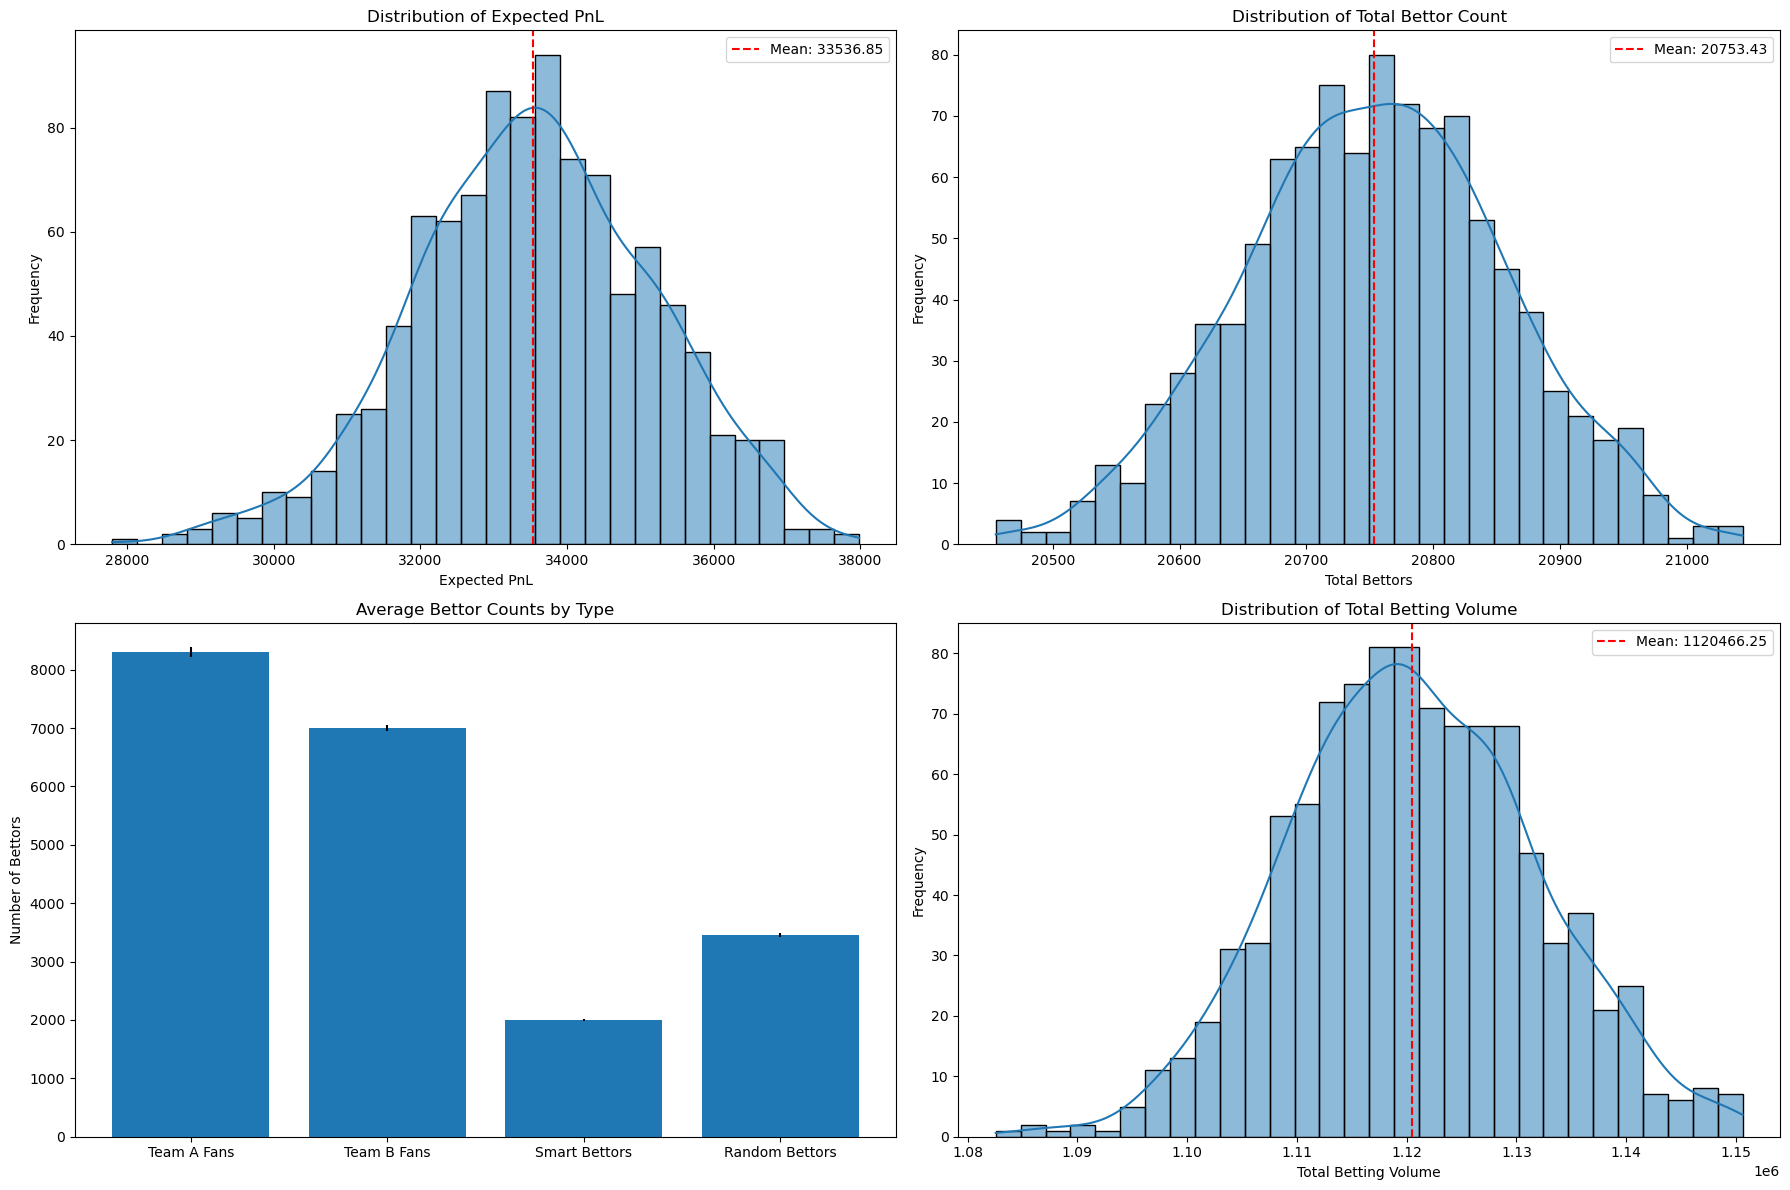

In [68]:
fig = plot_MC_results(sims)
plt.show()

In [69]:
analysis = analyze_MC_results(sims)
print("PnL Analysis:")
print(f"  Mean Expected PnL: ${analysis['pnl']['mean']:.2f}")
print(f"  Standard Deviation: ${analysis['pnl']['std']:.2f}")
print(f"  95% VaR: ${analysis['pnl']['var_95']:.2f}")
print(f"  Probability of Loss: {analysis['pnl']['prob_loss']*100:.2f}%")
print(f"  Mean PnL if Team A wins: ${analysis['pnl']['mean_if_A_wins']:.2f}")
print(f"  Mean PnL if Team B wins: ${analysis['pnl']['mean_if_B_wins']:.2f}")

print("\nVolume Analysis:")
print(f"  Mean Total Volume: ${analysis['volume']['mean_total']:.2f}")
print(f"  Team A to Team B Volume Ratio: {analysis['volume']['ratio_A_to_B']:.2f}")

PnL Analysis:
  Mean Expected PnL: $33536.85
  Standard Deviation: $1628.53
  95% VaR: $30870.42
  Probability of Loss: 0.00%
  Mean PnL if Team A wins: $39028.51
  Mean PnL if Team B wins: $21313.47

Volume Analysis:
  Mean Total Volume: $1120466.25
  Team A to Team B Volume Ratio: 1.50


# I need REAL data to see if this really work